In [1]:
import pandas as pd
from datetime import datetime
import mplfinance as fplt
import matplotlib.pyplot as plt
import numpy as np
import pyflux as pf

In [2]:
BTC_21 = pd.read_csv('BTC_21.csv', index_col = 'timestamp')
BTC_21.index = BTC_21.index.map(datetime.fromtimestamp)

In [3]:
####### Meta data #########
prior_period_time = 3*60 # 4 hour period
forecast_period = 60 # one hour
train_period = 30 * 1440 # 30 days


In [4]:
np.random.seed(123)
def create_train_test_dataframes(BTC_21, train_period, forecast_period):
    train_start = np.random.randint(0, BTC_21.shape[0] - train_period - forecast_period, 1)[0]
    train_end = train_start + train_period
    test_start = train_end + 1
    test_end = test_start + forecast_period

    train_df = BTC_21.iloc[train_start:train_end, :]
    test_df = BTC_21.iloc[test_start:test_end, :]
    return train_df, test_df
train_df, test_df = create_train_test_dataframes(BTC_21, train_period, forecast_period)
# orig_df = train_df.copy() # as this will be used to create time-frame based features

In [5]:
train_df.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2021-06-23 03:51:00,1,2126.0,33876.235714,33966.000000,33852.20,33902.070000,139.603211,33907.979681,0.000197
2021-06-23 03:52:00,1,1815.0,33903.096198,33940.533389,33816.47,33892.622764,76.487538,33875.830477,-0.000579
2021-06-23 03:53:00,1,3820.0,33901.940527,34055.880000,33876.50,33983.638185,285.560748,33979.126871,-0.000315
2021-06-23 03:54:00,1,1808.0,33977.644286,33995.670000,33895.37,33928.677143,88.080927,33946.471673,-0.000840
2021-06-23 03:55:00,1,1708.0,33926.034286,33972.653454,33856.78,33897.667143,67.985407,33902.790076,-0.001043


## Engineer features
1. weekend vs. weekdays
2. hour of transaction

In [6]:
def engineer_features(train_df, test_df, prior_period_time):

    train_df.loc[:, 'green_candel'] = np.where(train_df.Close > train_df.Open, 1, 0)
    train_df.loc[:, 'top_shadow'] = train_df.loc[:, 'High'] - train_df.loc[:, ['Open', 'Close']].max(axis = 1)
    train_df.loc[:, 'bottom_shadow'] = train_df.loc[:, ['Open', 'Close']].min(axis = 1) - train_df.loc[:, 'Low']
    train_df.loc[:, 'weekday'] = train_df.index.dayofweek
    train_df.loc[:, 'hour'] = train_df.index.hour
    train_df.loc[:, 'isweekend'] = (train_df.loc[:, 'weekday'] > 4).astype(int)
    train_df.loc[:, 'avg_green_candel'] = train_df.loc[:, 'green_candel'].rolling(window = prior_period_time).mean()
    train_df.loc[:, 'avg_top_shadow'] = train_df.loc[:, 'top_shadow'].rolling(window = prior_period_time).mean()
    train_df.loc[:, 'avg_bottom_shadow'] = train_df.loc[:, 'bottom_shadow'].rolling(window = prior_period_time).mean()
    test_features_df = pd.DataFrame(np.repeat(train_df.tail(1)[['avg_green_candel', 'avg_top_shadow', 'avg_bottom_shadow']].values, test_df.shape[0], axis = 0), 
                       index = test_df.index, columns = ['avg_green_candel', 'avg_top_shadow', 'avg_bottom_shadow'])
    test_df = pd.concat([test_df, test_features_df], axis = 'columns')
    return train_df, test_df

In [7]:
train, test = engineer_features(train_df, test_df, prior_period_time)

(array([ 3., 10.,  5.,  3., 11., 15.,  6.,  3.,  2.,  2.]),
 array([32549.326 , 32569.1244, 32588.9228, 32608.7212, 32628.5196,
        32648.318 , 32668.1164, 32687.9148, 32707.7132, 32727.5116,
        32747.31  ]),
 <a list of 10 Patch objects>)

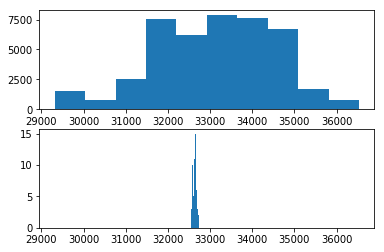

In [8]:
ax1 = plt.subplot(211)
plt.hist(train.Open)
ax2 = plt.subplot(212, sharex = ax1)
plt.hist(test.Open)

In [9]:
model = pf.ARIMAX(data=train, formula='Open~1+avg_green_candel+avg_top_shadow+avg_bottom_shadow',
                  ar=1, ma=1, integ = 1, family=pf.Normal())
x = model.fit("MLE")

In [10]:
x.summary()

Normal ARIMAX(1,1,1)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced Open                    Method: MLE                                       
Start Date: 2021-06-23 03:52:00                         Log Likelihood: -208022.4029                      
End Date: 2021-07-23 03:51:00                           AIC: 416058.8057                                  
Number of observations: 43019                           BIC: 416119.4915                                  
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    -0.1622    0.0596     -2.723   0.0065   (-0.2789 | -0.0454)      
MA(1)                                

In [56]:
predicted_values = model.predict(h = forecast_period, oos_data = test)
# transform the differenced values to the original
last_observation = train_df.tail(1)['Open'].values
predicted_values['Open'] = predicted_values['Differenced Open'].cumsum() + last_observation

In [78]:
starting_val = train_df.head(1)['Open'].values - model.y[0]
train_infered = np.cumsum(model.predict(h = forecast_period, oos_data = train_df)['Differenced Open']) + starting_val

In [79]:
train_infered.shape

(60,)

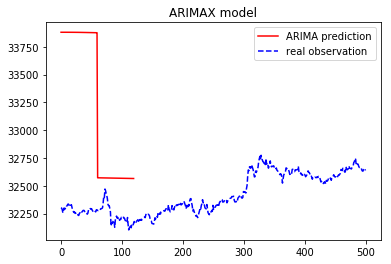

In [80]:
predicted_y = np.array(list(train_infered) + list(predicted_values.Open.values))[-500:]
real_y = np.array(list(train.Open.values) + list(test_df.Open.values))[-500:]
plt.plot(predicted_y, label = 'ARIMA prediction', color = 'red')
plt.plot(real_y, label = 'real observation', color ='blue', linestyle = 'dashed')
plt.title('ARIMAX model')
plt.legend()


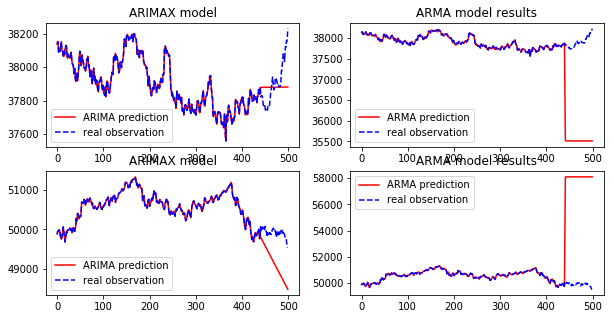

In [13]:
pred_number = 2
k = 1
plt.figure(figsize=(10, 5))
for i in range(pred_number):
    train_df, test_df = create_train_test_dataframes(BTC_21, train_period, forecast_period)
    train, test = engineer_features(train_df, test_df, prior_period_time)
    model = pf.ARIMAX(data=train, formula='Open~1+avg_green_candel+avg_top_shadow+avg_bottom_shadow',
                      ar=1, ma=1, family=pf.Normal())
    x = model.fit("MLE")
#     x.summary()
    plt.subplot(pred_number, 2, k)
    k += 1
    predicted_values = model.predict(h = forecast_period, oos_data = test)
    predicted_y = np.array(list(train.Open.values) + list(predicted_values.Open.values))[-500:]
    real_y = np.array(list(train.Open.values) + list(test_df.Open.values))[-500:]
    plt.plot(predicted_y, label = 'ARIMA prediction', color = 'red')
    plt.plot(real_y, label = 'real observation', color ='blue', linestyle = 'dashed')
    plt.title('ARIMAX model')
    plt.legend()
    #### ARMA model
    model = pf.ARIMA(data=train_df, ar=1, ma=1, target = 'Open', family=pf.Normal())
    x = model.fit("MLE")
#     x.summary()
    plt.subplot(pred_number, 2, k)
    k += 1
    predicted_values = model.predict(h = forecast_period)
    predicted_y = np.array(list(train.Open.values) + list(predicted_values.Open.values))[-500:]
    real_y = np.array(list(train.Open.values) + list(test_df.Open.values))[-500:]
    plt.plot(predicted_y, label = 'ARMA prediction', color = 'red')
    plt.plot(real_y, label = 'real observation', color ='blue', linestyle = 'dashed')
    plt.title('ARMA model results')
    plt.legend()
    
plt.show()

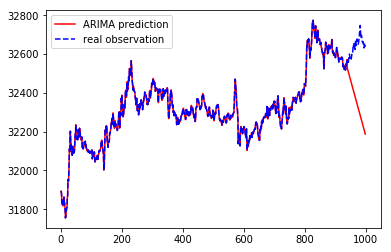

In [15]:

predicted_values = model.predict(h = forecast_period, oos_data = test)
predicted_values = model.predict(h = forecast_period, oos_data = test)
predicted_y = np.array(list(train.Open.values) + list(predicted_values.Open.values))[-1000:]
real_y = np.array(list(train.Open.values) + list(test_df.Open.values))[-1000:]

plt.plot(predicted_y, label = 'ARIMA prediction', color = 'red')
plt.plot(real_y, label = 'real observation', color ='blue', linestyle = 'dashed')
plt.legend()
plt.show()

In [132]:
model = pf.ARIMA(data=train_df, ar=1, ma=1, target = 'Open', family=pf.Normal())
x = model.fit("MLE")
x.summary()


Normal ARIMA(1,0,1)                                                                                       
======================================================= ==================================================
Dependent Variable: Open                                Method: MLE                                       
Start Date: 2021-06-23 03:52:00                         Log Likelihood: -1429555076.1834                  
End Date: 2021-07-23 03:51:00                           AIC: 2859110160.3668                              
Number of observations: 43199                           BIC: 2859110195.0611                              
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 33122.4989 0.6217     53276.15 0.0      (33121.2804 | 33123.7175)
AR(1)                                

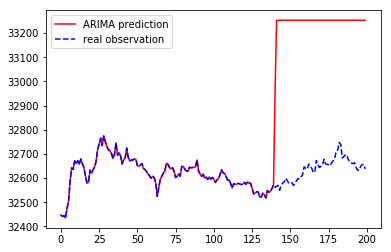

In [115]:
predicted_values = model.predict(h = forecast_period)
predicted_y = np.array(list(train_df.Open.values) + list(predicted_values.Open.values))[-200:]
real_y = np.array(list(train_df.Open.values) + list(test_df.Open.values))[-200:]

plt.plot(predicted_y, label = 'ARIMA prediction', color = 'red')
plt.plot(real_y, label = 'real observation', color ='blue', linestyle = 'dashed')
plt.legend()
plt.show()

In [99]:
# ohlc_dict = {                                                                                                             
# #     'Open': 'first',                                                                                                    
# #     'High': 'max',                                                                                                       
# #     'Low': 'min',                                                                                                        
# #     'Close': 'last',                                                                                                    
# #     'Volume': 'sum',
#     'green_candel': 'mean',
#     'top_shadow': 'mean',
#     'bottom_shadow': 'mean', 
# }
# trend_features = train_df.resample(prior_period_time).apply(ohlc_dict)
# pred_features = trend_features.tail(1)
# # shift the data as that is data should be used to train the model
# trend_features = trend_features.shift(1)[1:]

In [98]:
BTC_21['weekday'] = BTC_21.index.dayofweek
BTC_21['hour'] = BTC_21.index.hour
BTC_21['isweekend'] = (BTC_21['weekday'] > 4).astype(int)

In [6]:
BTC_21.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,weekday,hour,isweekend
timestamp,,,,,,,,,,,,
2021-01-01 00:01:00,1,4039.0,28985.511250,29086.90,28960.0,29032.387500,163.787036,29017.664870,0.000396,4,0,0
2021-01-01 00:02:00,1,1969.0,29031.175000,29079.56,28951.5,29002.956734,98.754670,29014.703526,-0.000069,4,0,0
2021-01-01 00:03:00,1,1689.0,29002.977509,29069.39,28967.8,29005.580000,55.202131,29003.078663,-0.000137,4,0,0
2021-01-01 00:04:00,1,1146.0,29004.293750,29057.73,28971.8,29000.490000,56.575903,29006.256629,-0.000682,4,0,0
2021-01-01 00:05:00,1,2088.0,28994.918934,29031.71,28929.3,28962.285818,70.319136,28972.005783,-0.000446,4,0,0


## ARIMAX Model

In [9]:
import pyflux as pf
print(24*60)

1440


In [78]:
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: Open                                Method: MLE                                       
Start Date: 2021-02-06 12:29:00                         Log Likelihood: -259144.8564                      
End Date: 2021-03-08 12:31:00                           AIC: 518303.7128                                  
Number of observations: 43199                           BIC: 518364.4279                                  
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    1.0001     0.0        23891.28 0.0      (1.0 | 1.0002)           
MA(1)                                

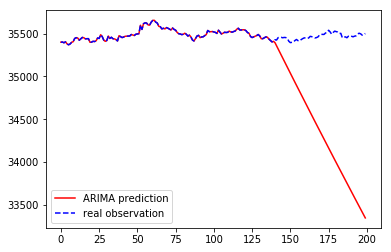

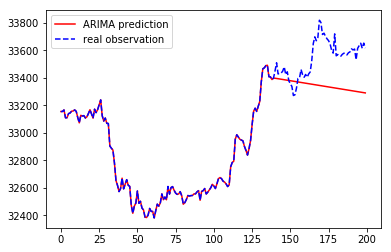

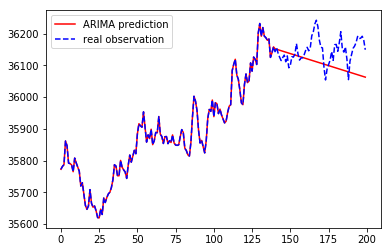

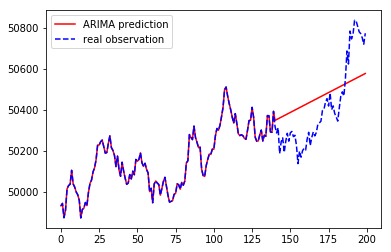

In [76]:
for i in range(4):
    train_start = np.random.randint(0, BTC_21.shape[0] - train_period - forecast_period, 1)[0]
    train_end = train_start + train_period
    test_start = train_end + 1
    test_end = test_start + forecast_period

    train_df = BTC_21.iloc[train_start:train_end, :]
    test_df = BTC_21.iloc[test_start:test_end, :]
    model = pf.ARIMAX(data=train_df, formula='Open~1+weekday+hour+isweekend',
                      ar=1, ma=1, family=pf.Normal())
    x = model.fit("MLE")
    # x.summary()
    predicted_values = model.predict(h = forecast_period, oos_data = test_df)
    MSE = test_df.Open.values - predicted_values.values
    predicted_y = np.array(list(train_df.Open.values) + list(predicted_values.Open.values))[-200:]
    real_y = np.array(list(train_df.Open.values) + list(test_df.Open.values))[-200:]

    plt.plot(predicted_y, label = 'ARIMA prediction', color = 'red')
    plt.plot(real_y, label = 'real observation', color ='blue', linestyle = 'dashed')
    plt.legend()
    plt.show()

## Changing the timeframe

In [26]:
ohlc_dict = {                                                                                                             
    'Open': 'first',                                                                                                    
    'High': 'max',                                                                                                       
    'Low': 'min',                                                                                                        
    'Close': 'last',                                                                                                    
    'Volume': 'sum',
}

daily_view = BTC_21.resample('D', closed='left', label='left').apply(ohlc_dict)

<Figure size 1500x1000 with 0 Axes>

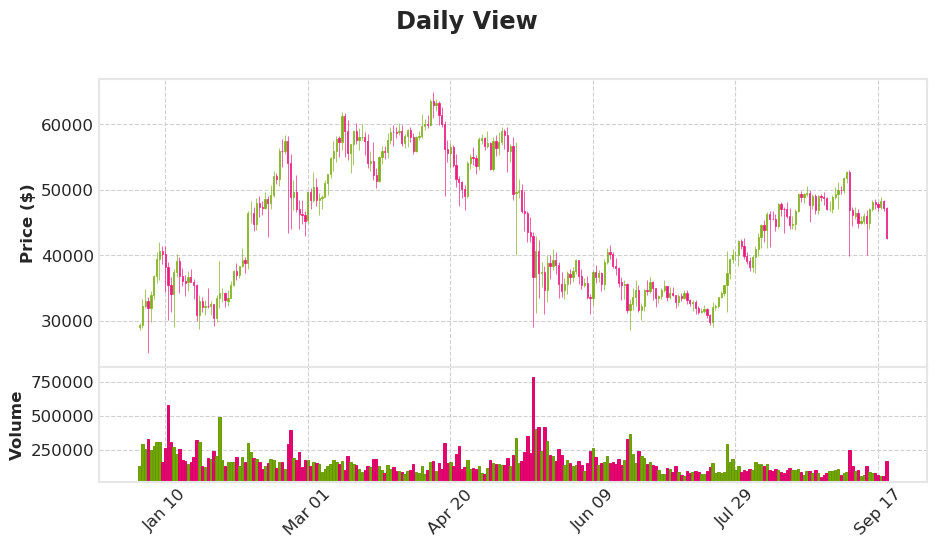

In [26]:
plt.figure(figsize = (15, 10))
fplt.plot(
            daily_view,
            type='candle',
            style = 'binance',
            title='Daily View',
            ylabel='Price ($)',
            volume = True,
            show_nontrading=True,
            figratio=(10,5),
#             mav = (2, 4, 6)
        )

/usr/local/anaconda/lib/python3.7/site-packages/mplfinance/_arg_validators.py:45: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


<Figure size 1080x720 with 0 Axes>

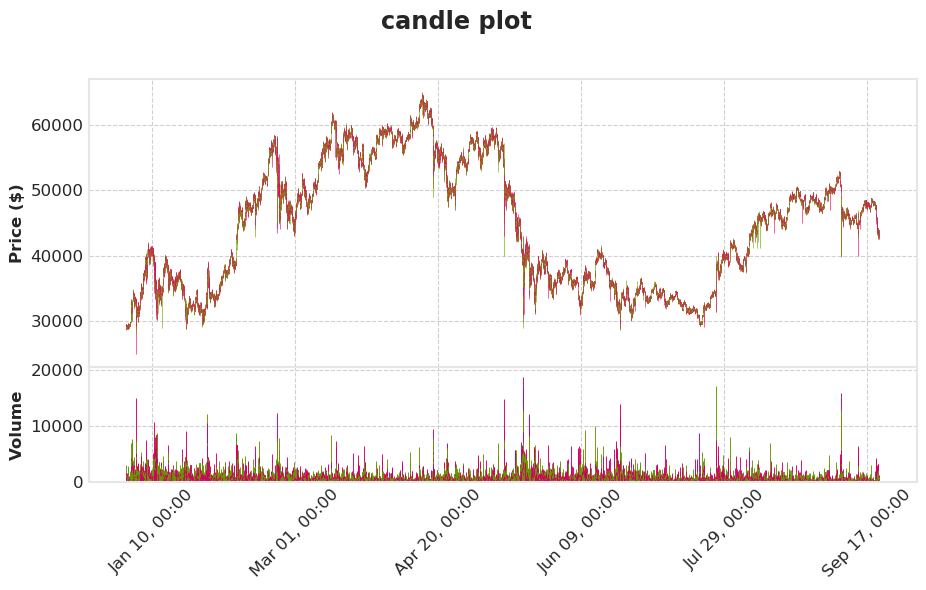

In [23]:
BTC_5min = BTC_21.resample('5T', closed='left', label='left').apply(ohlc_dict)

plt.figure(figsize = (15, 10))
fplt.plot(
            BTC_5min,
            type='candle',
            style = 'binance',
            title='candle plot',
            ylabel='Price ($)',
            volume = True,
            show_nontrading=True,
            figratio=(10,5),
#             mav = (2, 4, 6)
        )

In [40]:
BTC_5min['weekday'] = BTC_5min.index.dayofweek

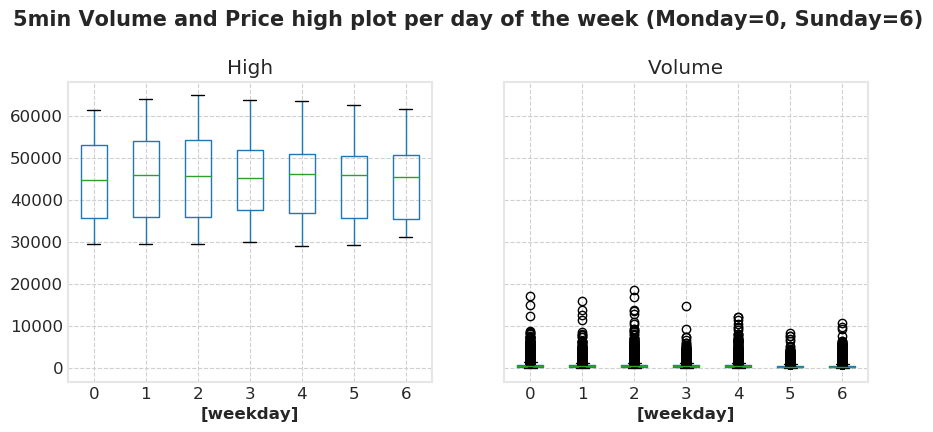

In [66]:
# plt.figure(figsize = (10, 5))
BTC_5min[['weekday', 'Volume', 'High']].boxplot(by = 'weekday', figsize = (10, 4)) # Monday=0, Sunday=6
# plt.title()
plt.suptitle('5min Volume and Price high plot per day of the week (Monday=0, Sunday=6)', size = 15, y=1.08)
# plt.xticks(rotation = 90)
plt.show()

In [71]:
hourly_view = BTC_21.resample('H', closed='left', label='left').apply(ohlc_dict)
hourly_view['hour'] = hourly_view.index.hour

In [74]:
hourly_view.head()

,Open,High,Low,Close,Volume,hour
timestamp,,,,,,
2021-01-01 00:00:00,28985.511250,29104.05,28687.10,29017.818333,5630.293179,0
2021-01-01 01:00:00,29026.086250,29545.00,28954.62,29437.590000,12808.485995,1
2021-01-01 02:00:00,29436.217500,29539.86,29091.00,29217.230000,6210.350787,2
2021-01-01 03:00:00,29217.758571,29417.61,29142.43,29312.804121,3318.342350,3
2021-01-01 04:00:00,29312.937143,29465.00,28850.00,29248.802857,4820.813820,4


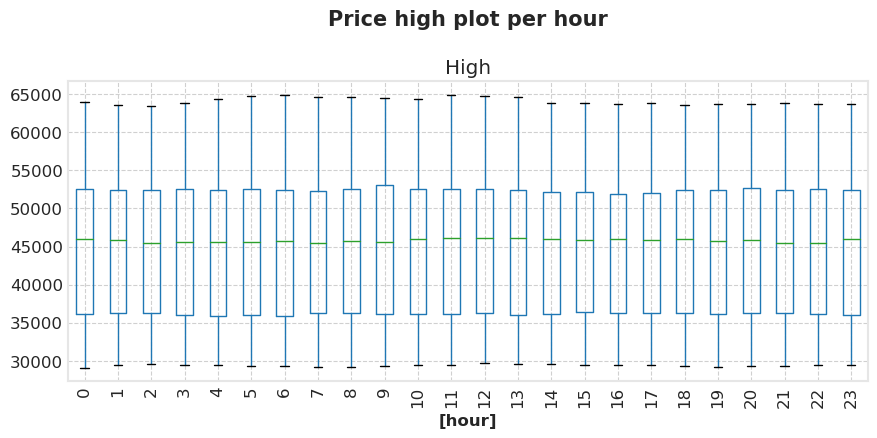

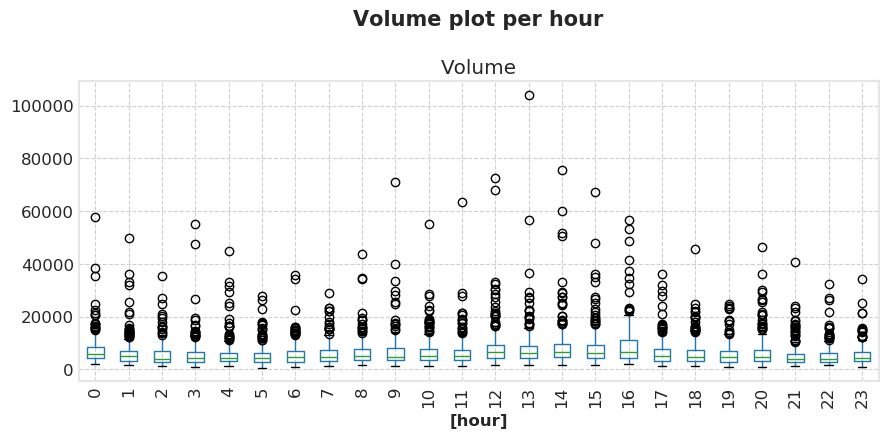

In [91]:
# get the hour from timestamp
hourly_view[['hour', 'High']].boxplot(by = 'hour', figsize = (10, 4), rot = 90) # Monday=0, Sunday=6
# plt.title()
plt.suptitle('Price high plot per hour', size = 15, y=1.08)
# plt.xticks(rotation = 90)
plt.show()
hourly_view[['hour', 'Volume']].boxplot(by = 'hour', figsize = (10, 4), rot = 90) # Monday=0, Sunday=6
# plt.title()
plt.suptitle('Volume plot per hour', size = 15, y=1.08)
# plt.xticks(rotation = 90)
plt.show()